# Extracting Features from the Bike Sharing Dataset

In [37]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
# first remove the headers by using the 'sed' command:
# sed 1d hour.csv > hour_noheader.csv
path = "D:\\Project\\Spark\\Machine-Learning-with-Spark\\Data\\Bike-Sharing-Dataset\\hour_noheader.csv"
raw_data = sc.textFile(path)
num_data = raw_data.count()
records = raw_data.map(lambda x: x.split(","))
first = records.first()

print (first)
print (num_data)

['1', '2011-01-01', '1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
17379


## Extract the variables we want to keep

_All variables:_

`instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt`

_Variables to keep:_

`season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt`

## Create feature mappings for categorical features

In [39]:
# cache the dataset to speed up subsequent operations
records.cache()

# function to get the categorical feature mapping for a given variable column
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

# we want to extract the feature mappings for columns 2 - 9
# try it out on column 2 first
print ("Mapping of first categorical feasture column: %s" % get_mapping(records, 2))

Mapping of first categorical feasture column: {'4': 0, '1': 1, '3': 2, '2': 3}


In [40]:
# extract all the catgorical mappings
mappings = [get_mapping(records, i) for i in range(2,10)]
cat_len = sum([*map(len, mappings)])
num_len = len(records.first()[11:15])
total_len = cat_len + num_len 

print ("Feature vector length for categorical features: %d" % cat_len)
print ("Feature vector length for numerical features: %d" % num_len)
print ("Total feature vector length: %d" % total_len)

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


## Create Feature Vectors

In [41]:
# required imports
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# function to use the feature mappings to extract binary feature vectors, and concatenate with
# the numerical feature vectors
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

# function to extract the label from the last column
def extract_label(record):
    return float(record[-1])

data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))
first_point = data.first()

print ("Raw data: " + str(first[2:]))
print ("Label: " + str(first_point.label))
print ("Linear Model feature vector:\n" + str(first_point.features))
print ("Linear Model feature vector length: " + str(len(first_point.features)))

Raw data: ['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Label: 16.0
Linear Model feature vector:
[0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


In [46]:
# we need a separate set of feature vectors for the decision tree
def extract_features_dt(record):
    #return np.array(map(float, record[2:14]))
    return np.array([float(field) for field in record[2:14]])
    
data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features_dt(r)))
first_point_dt = data_dt.first()

print ("Decision Tree feature vector: " + str(first_point_dt.features))
print ("Decision Tree feature vector length: " + str(len(first_point_dt.features)))

Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length: 12


# Training a Regression Model

In [47]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree

help(LinearRegressionWithSGD.train)

Help on method train in module pyspark.mllib.regression:

train(data, iterations=100, step=1.0, miniBatchFraction=1.0, initialWeights=None, regParam=0.0, regType=None, intercept=False, validateData=True, convergenceTol=0.001) method of builtins.type instance
    Train a linear regression model using Stochastic Gradient
    Descent (SGD). This solves the least squares regression
    formulation
    
        f(weights) = 1/(2n) ||A weights - y||^2
    
    which is the mean squared error. Here the data matrix has n rows,
    and the input RDD holds the set of rows of A, each with its
    corresponding right hand side label y.
    See also the documentation for the precise formulation.
    
    :param data:
      The training data, an RDD of LabeledPoint.
    :param iterations:
      The number of iterations.
      (default: 100)
    :param step:
      The step parameter used in SGD.
      (default: 1.0)
    :param miniBatchFraction:
      Fraction of data to be used for each SGD iteratio

In [48]:
help(DecisionTree.trainRegressor)

Help on method trainRegressor in module pyspark.mllib.tree:

trainRegressor(data, categoricalFeaturesInfo, impurity='variance', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0) method of builtins.type instance
    Train a decision tree model for regression.
    
    :param data:
      Training data: RDD of LabeledPoint. Labels are real numbers.
    :param categoricalFeaturesInfo:
      Map storing arity of categorical features. An entry (n -> k)
      indicates that feature n is categorical with k categories
      indexed from 0: {0, 1, ..., k-1}.
    :param impurity:
      Criterion used for information gain calculation.
      The only supported value for regression is "variance".
      (default: "variance")
    :param maxDepth:
      Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1
      means 1 internal node + 2 leaf nodes).
      (default: 5)
    :param maxBins:
      Number of bins used for finding splits at each node.
      (default: 32)
    :param mi

## Train a Regression Model on the Bike Sharing Dataset

In [49]:
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1, intercept=False)
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))

print ("Linear Model predictions: " + str(true_vs_predicted.take(5)))

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


Linear Model predictions: [(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834317)]


In [50]:
# we pass in an mepty mapping for categorical feature size {}
dt_model = DecisionTree.trainRegressor(data_dt, {})
preds = dt_model.predict(data_dt.map(lambda p: p.features))
actual = data.map(lambda p: p.label)
true_vs_predicted_dt = actual.zip(preds)

print ("Decision Tree predictions: " + str(true_vs_predicted_dt.take(5)))
print ("Decision Tree depth: " + str(dt_model.depth()))
print ("Decision Tree number of nodes: " + str(dt_model.numNodes()))

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


## Perfomance Metrics

In [51]:
# set up performance metrics functions 

def squared_error(actual, pred):
    return (pred - actual)**2

def abs_error(actual, pred):
    return np.abs(pred - actual)

def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

### Linear Model

In [54]:
# compute performance metrics for linear model
# mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean()
# mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean()
# rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean())

mse = true_vs_predicted.map(lambda p : squared_error(p[0], p[1])).mean()
mae = true_vs_predicted.map(lambda p : abs_error(p[0], p[1])).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda p : squared_log_error(p[0], p[1])).mean())


print ("Linear Model - Mean Squared Error: %2.4f" % mse)
print ("Linear Model - Mean Absolute Error: %2.4f" % mae)
print ("Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle)

Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


### Decision Tree Model

In [56]:
# compute performance metrics for decision tree model
# mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()
# ae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()
# rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())

mse_dt = true_vs_predicted_dt.map(lambda p: squared_error(p[0], p[1])).mean()
mae_dt = true_vs_predicted_dt.map(lambda p: abs_error(p[0], p[1])).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda p: squared_log_error(p[0], p[1])).mean())

print ("Decision Tree - Mean Squared Error: %2.4f" % mse_dt)
print ("Decision Tree - Mean Absolute Error: %2.4f" % mae_dt)
print ("Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt)

Decision Tree - Mean Squared Error: 11560.7978
Decision Tree - Mean Absolute Error: 71.0969
Decision Tree - Root Mean Squared Log Error: 0.6259


#### Using the categorical feature mapping for Decision Tree

In [59]:
# we create the categorical feature mapping for decision trees
cat_features = dict([(i - 2, len(get_mapping(records, i)) + 1) for i in range(2,10)])
print ("Categorical feature size mapping %s" % cat_features)

# train the model again
dt_model_2 = DecisionTree.trainRegressor(data_dt, categoricalFeaturesInfo=cat_features)
preds_2 = dt_model_2.predict(data_dt.map(lambda p: p.features))
actual_2 = data.map(lambda p: p.label)
true_vs_predicted_dt_2 = actual_2.zip(preds_2)

# compute performance metrics for decision tree model
mse_dt_2 = true_vs_predicted_dt_2.map(lambda p: squared_error(p[0], p[1])).mean()
mae_dt_2 = true_vs_predicted_dt_2.map(lambda p: abs_error(p[0], p[1])).mean()
rmsle_dt_2 = np.sqrt(true_vs_predicted_dt_2.map(lambda p: squared_log_error(p[0], p[1])).mean())

print ("Decision Tree - Mean Squared Error: %2.4f" % mse_dt_2)
print ("Decision Tree - Mean Absolute Error: %2.4f" % mae_dt_2)
print ("Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt_2)

Categorical feature size mapping {0: 5, 1: 3, 2: 13, 3: 25, 4: 3, 5: 8, 6: 3, 7: 5}
Decision Tree - Mean Squared Error: 8406.6133
Decision Tree - Mean Absolute Error: 60.7996
Decision Tree - Root Mean Squared Log Error: 0.6236


# Transforming the Target Variable
## Distributon of Raw Target

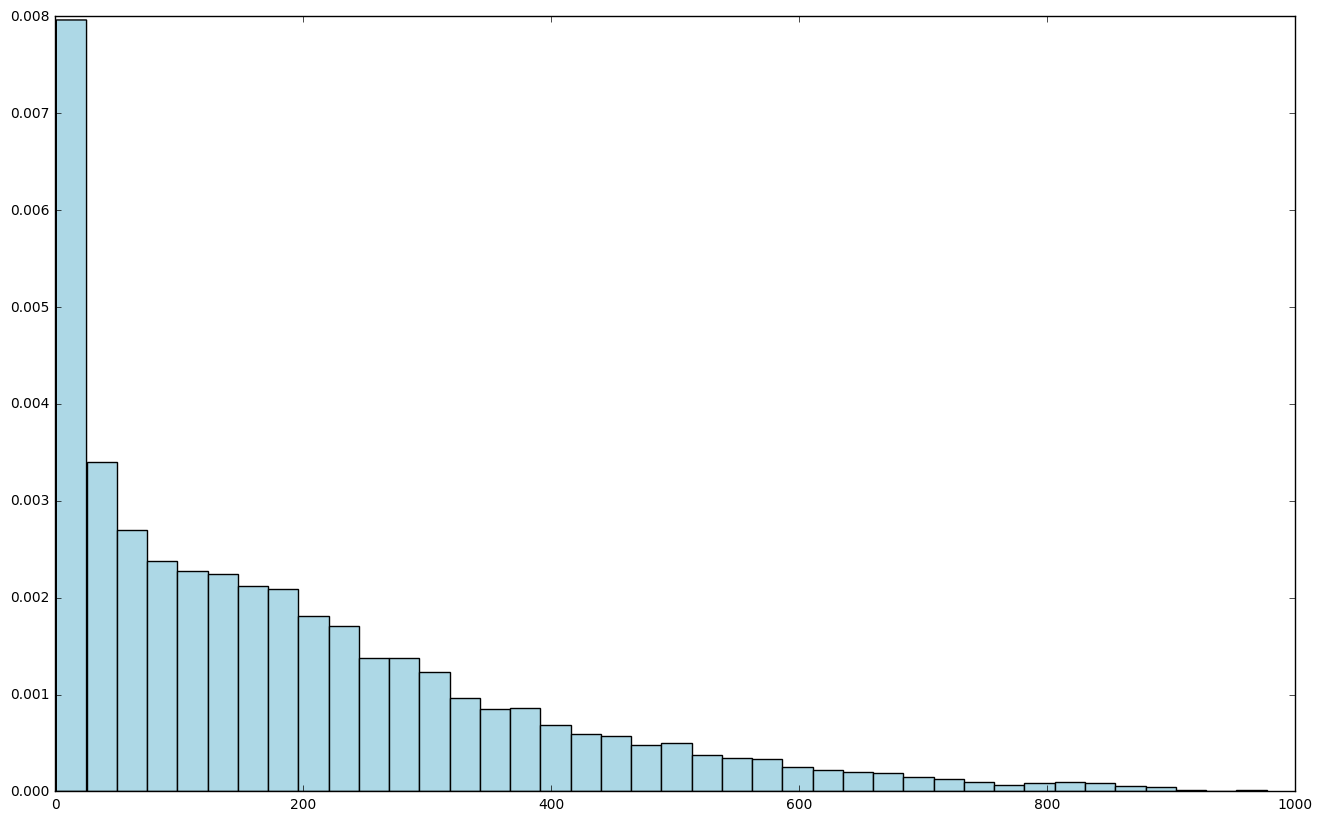

In [60]:
targets = records.map(lambda r: float(r[-1])).collect()
hist(targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

## Distribution of Log Transformed Target

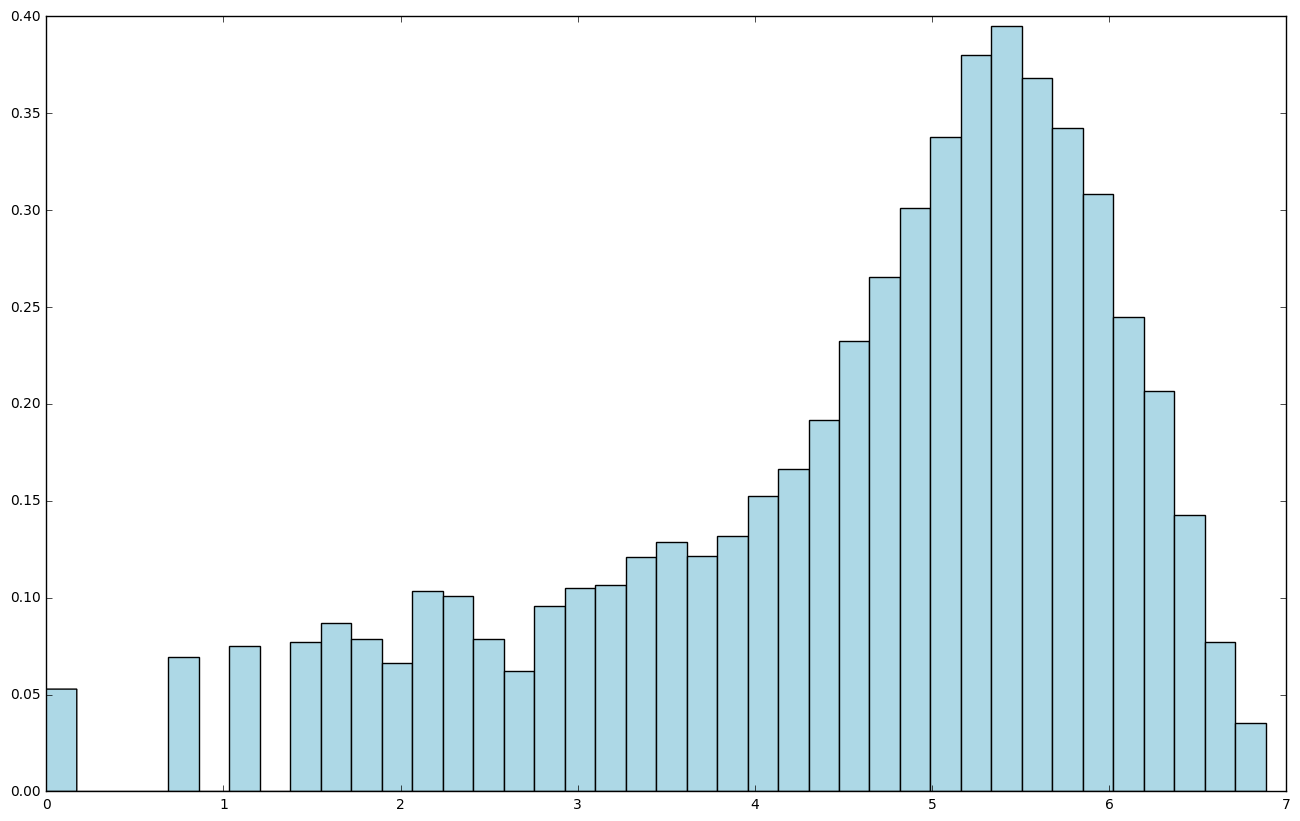

In [61]:
log_targets = records.map(lambda r: np.log(float(r[-1]))).collect()
hist(log_targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

## Distribution of Square-root Transformed target

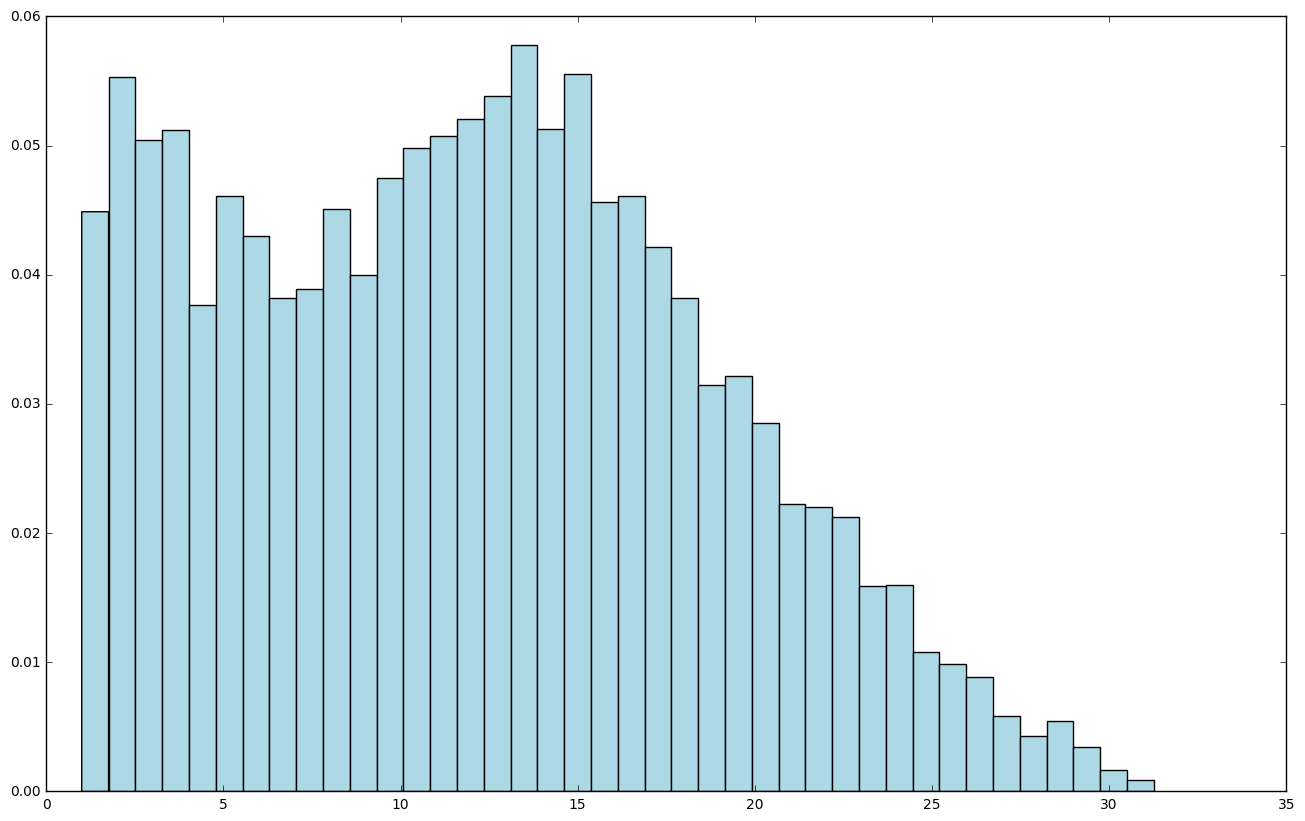

In [62]:
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()
hist(sqrt_targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

## Impact of Training on Log Transformed Targets

In [63]:
# train a linear model on log-transformed targets
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))
model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1)

true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features))))

mse_log = true_vs_predicted_log.map(lambda p: squared_error(p[0], p[1])).mean()
mae_log = true_vs_predicted_log.map(lambda p: abs_error(p[0], p[1])).mean()
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda p: squared_log_error(p[0], p[1])).mean())

print ("Mean Squared Error: %2.4f" % mse_log)
print ("Mean Absolute Error: %2.4f" % mae_log)
print ("Root Mean Squared Log Error: %2.4f" % rmsle_log)
print ("Non log-transformed predictions:\n" + str(true_vs_predicted.take(3)))
print ("Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3)))

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


Mean Squared Error: 50685.5559
Mean Absolute Error: 155.2955
Root Mean Squared Log Error: 1.5411
Non log-transformed predictions:
[(16.0, 117.89250386724846), (40.0, 116.2249612319211), (32.0, 116.02369145779235)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456223), (40.0, 26.959480191001784), (32.0, 26.654725629458021)]


In [64]:
# train a decision tree model on log-transformed targets
data_dt_log = data_dt.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))
dt_model_log = DecisionTree.trainRegressor(data_dt_log, {})

preds_log = dt_model_log.predict(data_dt_log.map(lambda p: p.features))
actual_log = data_dt_log.map(lambda p: p.label)
true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda p: (np.exp(p[0]), np.exp(p[1])))

mse_log_dt = true_vs_predicted_dt_log.map(lambda p: squared_error(p[0], p[1])).mean()
mae_log_dt = true_vs_predicted_dt_log.map(lambda p: abs_error(p[0], p[1])).mean()
rmsle_log_dt = np.sqrt(true_vs_predicted_dt_log.map(lambda p: squared_log_error(p[0], p[1])).mean())

print ("Mean Squared Error: %2.4f" % mse_log_dt)
print ("Mean Absolute Error: %2.4f" % mae_log_dt)
print ("Root Mean Squared Log Error: %2.4f" % rmsle_log_dt)
print ("Non log-transformed predictions:\n" + str(true_vs_predicted_dt.take(3)))
print ("Log-transformed predictions:\n" + str(true_vs_predicted_dt_log.take(3)))

Mean Squared Error: 14781.5760
Mean Absolute Error: 76.4131
Root Mean Squared Log Error: 0.6406
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions:
[(15.999999999999998, 37.530779787154508), (40.0, 37.530779787154508), (32.0, 7.2797070993907287)]


# Cross-validation
## Creating Training and Test Sets

In [66]:
# create training and testing sets for linear model
data_with_idx = data.zipWithIndex().map(lambda p: (p[1], p[0]))
test = data_with_idx.sample(False, 0.2, 42)
train = data_with_idx.subtractByKey(test)

train_data = train.map(lambda p: p[1])
test_data = test.map(lambda p: p[1])

train_size = train_data.count()
test_size = test_data.count()

print ("Training data size: %d" % train_size)
print ("Test data size: %d" % test_size)
print ("Total data size: %d " % num_data)
print ("Train + Test size : %d" % (train_size + test_size))

Training data size: 13869
Test data size: 3510
Total data size: 17379 
Train + Test size : 17379


In [69]:
# create training and testing sets for decision tree
data_with_idx_dt = data_dt.zipWithIndex().map(lambda p: (p[1], p[0]))
test_dt = data_with_idx_dt.sample(False, 0.2, 42)
train_dt = data_with_idx_dt.subtractByKey(test_dt)

train_data_dt = train_dt.map(lambda p: p[1])
test_data_dt = test_dt.map(lambda p : p[1])

## Evaluating the Impact of Different Parameter Settings for Linear Model

In [70]:
# create a function to evaluate linear model
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda p: squared_log_error(p[0], p[1])).mean())
    return rmsle

### Iterations

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[1, 5, 10, 20, 50, 100]
[2.8914055150732545, 2.0430992987776735, 1.7742287660542899, 1.5738717456816069, 1.4193495082740306, 1.3796611089716069]


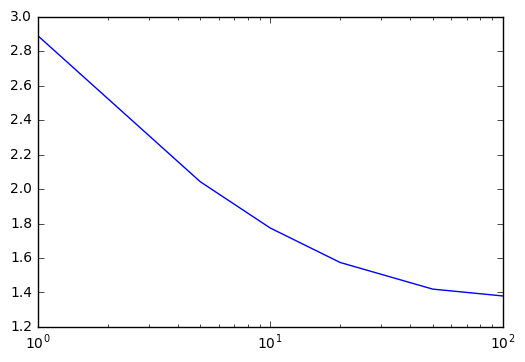

In [71]:
params = [1, 5, 10, 20, 50, 100]
metrics = [evaluate(train_data, test_data, param, 0.01, 0.0, 'l2', False) for param in params]

print (params)
print (metrics)

plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

### Step Size

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")
C:\Programs\spark\python\pyspark\statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
C:\Programs\spark\python\pyspark\statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


[0.01, 0.025, 0.05, 0.1, 1.0]
[1.7742287660542899, 1.418982453615184, 1.3888231497870642, 1.4673697834450803, nan]


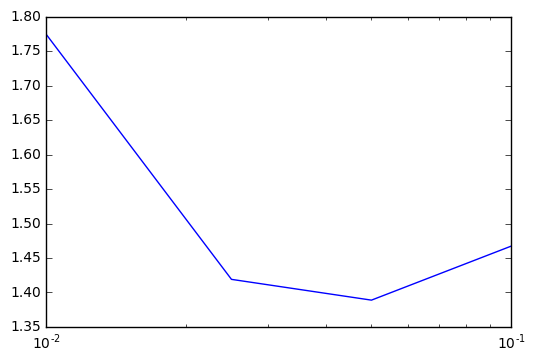

In [72]:
params = [0.01, 0.025, 0.05, 0.1, 1.0]
metrics = [evaluate(train_data, test_data, 10, param, 0.0, 'l2', False) for param in params]

print (params)
print (metrics)

plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

### L2 Regularization

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.4673697834450803, 1.4667256815761693, 1.4610397860552227, 1.4148656991945883, 1.3894093337429676, 1.5268171913629869, 1.8274812568879655]


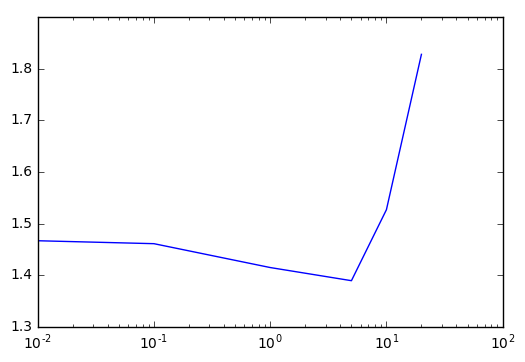

In [73]:
params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l2', False) for param in params]

print (params)
print (metrics)

plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

### L1 Regularization

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.4673697834450803, 1.4673349810789962, 1.4670244797589551, 1.4641307492983522, 1.4373867040546628, 1.7500923424654888, 4.7732667371201707]


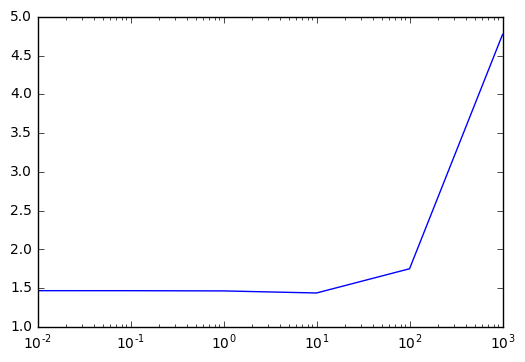

In [74]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]

print (params)
print (metrics)

plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

In [75]:
# Investigate sparsity of L1-regularized solution
model_l1 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=1.0, regType='l1', intercept=False)
model_l1_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=10.0, regType='l1', intercept=False)
model_l1_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=100.0, regType='l1', intercept=False)

print ("L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0)))
print ("L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0)))
print ("L1 (100.0) number of zeros weights: " + str(sum(model_l1_100.weights.array == 0)))

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


L1 (1.0) number of zero weights: 5
L1 (10.0) number of zeros weights: 33
L1 (100.0) number of zeros weights: 58


### Intercept

C:\Programs\spark\python\pyspark\mllib\regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


[False, True]
[1.4148656991945883, 1.4456134673412357]


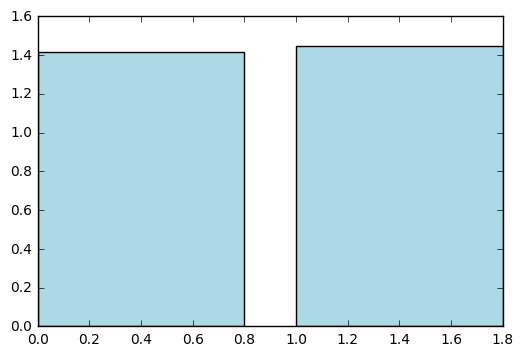

In [76]:
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param) for param in params]

print (params)
print (metrics)

bar(params, metrics, color='lightblue')
fig = matplotlib.pyplot.gcf()

## Evaluating the Impact of Different Parameter Settings for Decision Tree Model

In [78]:
# create a function to evaluate decision tree model
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train, {}, impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds = model.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda p: squared_log_error(p[0], p[1])).mean())
    return rmsle

### Tree Depth

[1, 2, 3, 4, 5, 10, 20]
[1.0100243237245241, 0.90905272211847488, 0.81109711802469608, 0.7322966176210407, 0.63990976968359503, 0.4201276945230874, 0.45486651553386265]


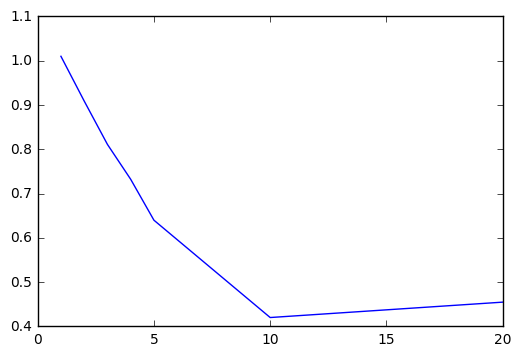

In [79]:
params = [1, 2, 3, 4, 5, 10, 20]
metrics = [evaluate_dt(train_data_dt, test_data_dt, param, 32) for param in params]

print (params)
print (metrics)

plot(params, metrics)
fig = matplotlib.pyplot.gcf()

### Max Bins

[2, 4, 8, 16, 32, 64, 100]
[1.2701534921385094, 0.80129728469147588, 0.73542372843123194, 0.6251623955270379, 0.63990976968359503, 0.63990976968359503, 0.63990976968359503]


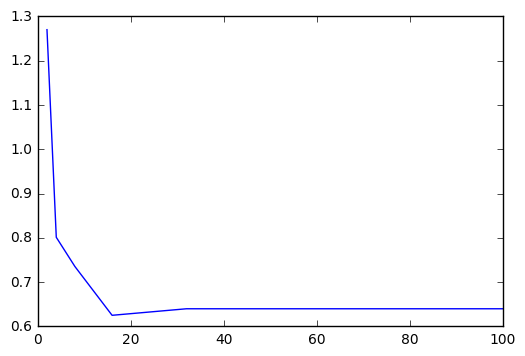

In [80]:
params = [2, 4, 8, 16, 32, 64, 100]
metrics = [evaluate_dt(train_data_dt, test_data_dt, 5, param) for param in params]

print (params)
print (metrics)

plot(params, metrics)
fig = matplotlib.pyplot.gcf()